<code>damped_anom_forecast_RMSE.ipynb</code>.  This notebook just quickly calculates the RMSE, MAE, and raw error for the damped anomaly forecast.  

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import os
from S2S_sea_ice_preprocess import create_aggregate_regions, create_obs_climatology, create_obs_climatology_ROLLING
from S2S_sea_ice_VRILEs import get_VRILE_days
from S2S_sea_ice_errors import calculate_errors

Load the damped anomaly data

In [19]:
vrile_thresh = 0.05
thresh_str = '05'
nday_change = 5
seas_sel = [1,2,3,4,5,6,7,8,9,10,11,12]
seas_str = 'ALL'
nyear_roll = 10
lead_weeks = True
ROLL_CLIM = True
dates_SHIFT = 0

In [20]:
obs_name = 'NSIDC_0079'
fpath_load = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/data/'
fname_load = fpath_load+'DAMPED_ANOMALY_FORECAST_{nyear_roll}_rolling_mean.csv'.format(nyear_roll=nyear_roll)
SIE_damped_a = pd.read_csv(fname_load)
SIE_damped_a['init year'] = pd.to_datetime(SIE_damped_a['init date']).dt.year
SIE_damped_a['lead time (days)'] = pd.to_timedelta(SIE_damped_a['lead time'],'D')
# Trim to common reforecast period
SIE_damped_a = SIE_damped_a[SIE_damped_a['init year'].isin(np.arange(1999,2015))]
SIE_damped = SIE_damped_a.set_index('region')

Load the observations

In [21]:
obs_type = 'sipn_nc_yearly_agg'
filepath = '/home/disk/sipn/nicway/data/obs/{model_name}/{model_type}/'.format(model_name=obs_name,
                                                                              model_type=obs_type)
obs_filenames = xr.open_mfdataset(filepath+'/*.nc',combine='by_coords')
print('opening ',obs_filenames)
obs_SIE = obs_filenames.Extent
obs_regions = obs_filenames.nregions
obs_region_names = obs_filenames['region_names'].values
# Drop region names and re-add as a non-dask.array object.  This is stupid but oh well
obs_SIE = obs_SIE.drop('region_names')
obs_SIE["region_names"] = ("nregions",obs_region_names)
print('obs loaded')

opening  <xarray.Dataset>
Dimensions:       (nregions: 15, time: 11322)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * time          (time) datetime64[ns] 1989-01-01 1989-01-02 ... 2019-12-31
Data variables:
    Extent        (time, nregions) float64 dask.array<chunksize=(365, 15), meta=np.ndarray>
obs loaded


Add aggregate regions to obs and convert obs to Pandas dataframe

In [22]:
obs_SIE = create_aggregate_regions(obs_SIE)
obs_SIE = obs_SIE.to_dataframe().reset_index()
obs_SIE = obs_SIE.rename(columns={'Extent':'SIE','region_names':'region','time':'valid date'})
obs_SIE['init year'] = pd.to_datetime(obs_SIE['valid date']).dt.year


Create climatology.  We can either do a rolling mean (what we use to create the damped anomaly forecast) or a static mean of the 15 years we include in our data set

In [23]:
n_year_roll = 10
if ROLL_CLIM:
    obs_SIE = create_obs_climatology_ROLLING(obs_SIE,10)
    obs_SIE = obs_SIE[obs_SIE['init year'].isin(np.arange(1999,2015))]
    #obs_SIE = obs_SIE[obs_SIE['init year'].isin(np.arange(1,2017))]
    print('rolling mean climatology')
else:
    #obs_SIE = obs_SIE[obs_SIE['init year'].isin(np.arange(1999,2016))]
    #obs_SIE = obs_SIE[obs_SIE['init year'].isin(np.arange(1,2017))]
    obs_SIE = create_obs_climatology(obs_SIE)
    print('static climatology')
    
    
obs_SIE = obs_SIE.set_index('region')
obs_SIE

rolling mean climatology


,valid date,nregions,SIE,init year,valid day of year,SIE clim,SIE anom
region,,,,,,,
panArctic,1999-01-01,99,14.042518,1999,01-01,14.172305,-1.297863e-01
Sea of Okhotsk,1999-01-01,2,0.755715,1999,01-01,0.608966,1.467492e-01
Bering,1999-01-01,3,0.567497,1999,01-01,0.573428,-5.930634e-03
Hudson Bay,1999-01-01,4,1.233464,1999,01-01,1.233405,5.833550e-05
St John,1999-01-01,5,0.030842,1999,01-01,0.078435,-4.759259e-02
...,...,...,...,...,...,...,...
Kara-Laptev Sea,2014-12-31,20,1.791022,2014,12-31,1.772329,1.869320e-02
Barents-Kara-Laptev Sea,2014-12-31,21,2.417750,2014,12-31,2.298453,1.192975e-01
East Siberian-Beaufort-Chukchi Sea,2014-12-31,22,3.074202,2014,12-31,3.074202,4.440892e-16


Calculate VRILE days based on observations

In [24]:

obs_SIE_VRILE_onlyx, obs_SIE_anom_VRILE_onlyx, obs_SIE_NO_VRILEx, obs_SIE_anom_NO_VRILEx = get_VRILE_days(obs_SIE,vrile_thresh,nday_change,seas_sel,seas_str)

In [25]:
obs_SIE_VRILE_only = obs_SIE_VRILE_onlyx.set_index(['region'])
obs_SIE_anom_VRILE_only = obs_SIE_anom_VRILE_onlyx.set_index(['region'])
#
obs_SIE_NO_VRILE = obs_SIE_NO_VRILEx.set_index(['region'])
obs_SIE_anom_NO_VRILE = obs_SIE_anom_NO_VRILEx.set_index(['region'])


We want to be able to start our predictions of VRILE days BEFORE the VRILE happens, if desired.  So we shift the dates back by <code>dates_SHIFT</code>

In [26]:
obs_SIE_VRILE_only['valid date SHIFTED'] = obs_SIE_VRILE_only['valid date'] - pd.Timedelta(dates_SHIFT,'D')
obs_SIE_anom_VRILE_only['valid date SHIFTED'] = obs_SIE_anom_VRILE_only['valid date'] - pd.Timedelta(dates_SHIFT,'D')

Sort damped anomaly forecasts into VRILE days and nonVRILE days

In [27]:
SIE_df = SIE_damped.reset_index().copy()
SIE_reg = SIE_df.set_index(['region'])
regions_list = SIE_df['region'].unique().tolist()
SIE_no_VRILES = pd.DataFrame()
SIE_anom_no_VRILES = pd.DataFrame()
#
SIE_VRILES = pd.DataFrame()
SIE_anom_VRILES = pd.DataFrame()
for i_region in regions_list:
    if i_region == 'St John':
        continue
    SIE_ivrile = SIE_reg.loc[i_region][pd.to_datetime(SIE_reg.loc[i_region]['valid date']).isin(pd.to_datetime(obs_SIE_VRILE_only.loc[i_region]['valid date SHIFTED']))]
    SIE_VRILES = SIE_VRILES.append(SIE_ivrile)
#    #
    SIE_anom_ivrile = SIE_reg.loc[i_region][pd.to_datetime(SIE_reg.loc[i_region]['valid date']).isin(pd.to_datetime(obs_SIE_anom_VRILE_only.loc[i_region]['valid date SHIFTED']))]
    SIE_anom_VRILES = SIE_anom_VRILES.append(SIE_anom_ivrile)
#    #
    SIE_no_ivrile = SIE_reg.loc[i_region][pd.to_datetime(SIE_reg.loc[i_region]['valid date']).isin(pd.to_datetime(obs_SIE_NO_VRILE.loc[i_region]['valid date']))]
    SIE_no_VRILES = SIE_no_VRILES.append(SIE_no_ivrile)
    #
    SIE_anom_no_ivrile = SIE_reg.loc[i_region][pd.to_datetime(SIE_reg.loc[i_region]['valid date']).isin(pd.to_datetime(obs_SIE_anom_NO_VRILE.loc[i_region]['valid date']))]
    SIE_anom_no_VRILES = SIE_anom_no_VRILES.append(SIE_anom_no_ivrile)

Get lead time in weeks

In [28]:
week_length = 7
#pd.to_timedelta(SIE_anom_VRILES['lead time'],'D').dt.days/7
SIE_anom_VRILES['lead time (weeks)'] = np.floor(SIE_anom_VRILES['lead time (days)'].dt.days/week_length)
SIE_VRILES['lead time (weeks)'] = np.floor(SIE_VRILES['lead time (days)'].dt.days/week_length)
SIE_anom_no_VRILES['lead time (weeks)'] = np.floor(SIE_anom_no_VRILES['lead time (days)'].dt.days/week_length)
SIE_no_VRILES['lead time (weeks)'] = np.floor(SIE_no_VRILES['lead time (days)'].dt.days/week_length)

In [29]:
#foo = SIE_VRILES.copy()
#foo['valid date'] = pd.to_datetime(foo['valid date'])
SIE_VRILES['valid date'] = pd.to_datetime(SIE_VRILES['valid date'])
SIE_no_VRILES['valid date'] = pd.to_datetime(SIE_no_VRILES['valid date'])
SIE_anom_VRILES['valid date'] = pd.to_datetime(SIE_anom_VRILES['valid date'])
SIE_anom_no_VRILES['valid date'] = pd.to_datetime(SIE_anom_no_VRILES['valid date'])
#pd.to_datetime(obs_SIE_VRILE_only['valid date']).dt.date.unique().tolist()

Sort by init date just to make more sense in my brain

In [30]:
SIE_VRILES= SIE_VRILES.sort_values(by='init date')
SIE_no_VRILES = SIE_no_VRILES.sort_values(by='init date')
SIE_anom_VRILES = SIE_anom_VRILES.sort_values(by='init date')
SIE_anom_no_VRILES = SIE_anom_no_VRILES.sort_values(by='init date')

Finally, calculate errors

In [31]:
if lead_weeks == True:
    clim_freq_str = 'WEEKLY'
    SIE_VRILES['lead days'] = SIE_VRILES['lead time (weeks)']
    SIE_anom_VRILES['lead days'] = SIE_anom_VRILES['lead time (weeks)']
    SIE_raw_err,SIE_errors = calculate_errors(SIE_VRILES,obs_SIE_VRILE_only)
    SIE_anom_raw_err,SIE_anom_errors = calculate_errors(SIE_anom_VRILES,obs_SIE_anom_VRILE_only)
    ## NO VRILES
    SIE_no_VRILES['lead days'] = SIE_no_VRILES['lead time (weeks)']
    SIE_anom_no_VRILES['lead days'] = SIE_anom_no_VRILES['lead time (weeks)']
    SIE_raw_err_NO,SIE_errors_NO = calculate_errors(SIE_no_VRILES,obs_SIE_NO_VRILE)
    SIE_anom_raw_err_NO,SIE_anom_errors_NO = calculate_errors(SIE_anom_no_VRILES,obs_SIE_anom_NO_VRILE)
else:
    clim_freq_str = 'DAILY'
    SIE_VRILES['lead days'] = SIE_VRILES['lead time (days)'].dt.days
    SIE_anom_VRILES['lead days'] = SIE_anom_VRILES['lead time (days)'].dt.days
    SIE_raw_err,SIE_errors = calculate_errors(SIE_VRILES,obs_SIE_VRILE_only)
    SIE_anom_raw_err,SIE_anom_errors = calculate_errors(SIE_anom_VRILES,obs_SIE_anom_VRILE_only)
    ## NO VRILES
    SIE_no_VRILES['lead days'] = SIE_no_VRILES['lead time (days)'].dt.days
    SIE_anom_no_VRILES['lead days'] = SIE_anom_no_VRILES['lead time (days)'].dt.days
    SIE_raw_err_NO,SIE_errors_NO = calculate_errors(SIE_no_VRILES,obs_SIE_NO_VRILE)
    SIE_anom_raw_err_NO,SIE_anom_errors_NO = calculate_errors(SIE_anom_no_VRILES,obs_SIE_anom_NO_VRILE)
print('errors calculated')

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/FINAL/CODE/S2S_sea_ice_errors.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  SIE_obsx = obs_SIE.groupby(['region','valid date'])['SIE','SIE clim','SIE anom'].mean()
/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/FINAL/CODE/S2S_sea_ice_errors.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  SIE_model_raw = model_SIE.groupby(['region','valid date','lead days','init date'])['SIE','SIE clim','SIE anom'].mean()
/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/FINAL/CODE/S2S_sea_ice_errors.py:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  SIE_modelx = model_SIE.groupby(['region','valid date','lead days'])['SIE','SIE clim','SIE anom'].mean()


errors calculated


In [32]:
SIE_errors

SIE RMSE  SIE anom RMSE   SIE MAE  SIE anom MAE
region    lead days                                                 
Atlantic  0.0        0.052382       0.052380  0.041317      0.041310
          1.0        0.084127       0.084037  0.065741      0.065607
          2.0        0.099408       0.099245  0.077739      0.077561
          3.0        0.103611       0.103457  0.081783      0.081602
          4.0        0.109953       0.109792  0.089800      0.089656
...                       ...            ...       ...           ...
panArctic 4.0        0.481004       0.481004  0.384803      0.384803
          5.0        0.512563       0.512563  0.407279      0.407279
          6.0        0.534748       0.535150  0.425767      0.426364
          7.0        0.551662       0.552024  0.439088      0.439836
          8.0        0.567296       0.567251  0.450446      0.450119

[171 rows x 4 columns]

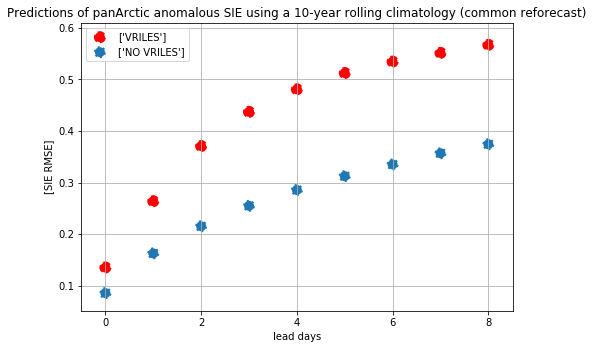

In [33]:
import matplotlib.pyplot as plt
fig1 = plt.figure(1)
ax1 = fig1.add_axes([0,0,1,1])
foo = SIE_errors.xs('panArctic').reset_index()
foo.plot.scatter(x='lead days',y=['SIE RMSE'],linewidth=2,linestyle='--',ax=ax1,color='r',label=['VRILES'],s=100)
foo2 = SIE_errors_NO.xs('panArctic').reset_index()
foo2.plot.scatter(x='lead days',y=['SIE RMSE'],linewidth=2,linestyle=':',ax=ax1,label=['NO VRILES'],s=100)
ax1.set_title('Predictions of panArctic anomalous SIE using a 10-year rolling climatology (common reforecast)')
ax1.grid()
#fig1.savefig('../../SIE_anom_test_damped_anom_clim_rolling_COMMON_REFORECAST.png',format='png',bbox_inches='tight')

Replace <code>SIE anom RMSE</code> and <code>SIE anom MAE</code> in <code>SIE_errors</code> with corresponding entries from  <code>SIE_anom_errors</code> (and same for raw)

In [ ]:
SIE_errors[['SIE anom RMSE','SIE anom MAE']] = SIE_anom_errors[['SIE anom RMSE','SIE anom MAE']]
SIE_raw_err['SIE anom'] = SIE_anom_raw_err['SIE anom']
SIE_errors_NO[['SIE anom RMSE','SIE anom MAE']] = SIE_anom_errors_NO[['SIE anom RMSE','SIE anom MAE']]
#SIE_raw_err_NO[['SIE anom']] = SIE_anom_raw_err_NO['SIE anom']

In [ ]:
SIE_errors['type'] = 'VRILE days'
SIE_errors_NO['type'] = 'no VRILE days'
SIE_errors_all = SIE_errors.append(SIE_errors_NO)

Save files!

In [ ]:
model_name = 'DAMPED_ANOMALY'
fdir = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/data/{model_name}/'.format(model_name=model_name)
if obs_name == 'NSIDC_0051':
    fdir = fdir+'OBS_{obs_name}/'.format(obs_name=obs_name)
if lead_weeks == True:
    fdir = fdir+'lead_time_WEEKS/'
if ROLL_CLIM == False:
    fdir = fdir+'STATIC_CLIM/'
if not os.path.exists(fdir):
    os.makedirs(fdir)

fname_save_raw = fdir+'RAW_err_{model_name}_months{seas_str}_VRILE{thresh_str}_model_clim_freq_{clim_freq_str}.csv'.format(model_name=model_name,
                                             seas_str=seas_str,thresh_str=thresh_str,clim_freq_str=clim_freq_str)
fname_save_RMSE = fdir+'VRILE_vs_NOVRILE_RMSE_MAE_{model_name}_months{seas_str}_VRILE{thresh_str}_model_clim_freq_{clim_freq_str}.csv'.format(model_name=model_name,
                                             seas_str=seas_str,thresh_str=thresh_str,clim_freq_str=clim_freq_str)
#SIE_raw_err.to_csv(fname_save_raw)
SIE_errors_all.to_csv(fname_save_RMSE)
print('files saved')

In [ ]:
fname_save_RMSE